Size of k-space slice reduced from 512x8x512
to 512x8x256
Apply Gaussian weighting function along readout
Close Figure 1 window to continue...


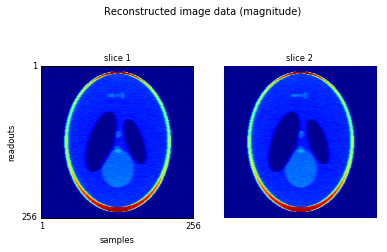

0

In [1]:
#'''
#Medium-level interface demo that illustrates 2D Cartesian MR image 
#reconstruction using Gadgetron by creating and running multiple gadget chains
#of 3 types:
#- acquisition processing chain
#- reconstruction chain
#- image processing chain
#and how to visualise or modify data in between these chains.
#
#Usage:
#  fully_sampled_recon_three_chains.py [--help | options]
#
#Options:
#  -f <file>, --file=<file>    raw data file
#                              [default: simulated_MR_2D_cartesian.h5]
#  -p <path>, --path=<path>    path to data files, defaults to data/examples/MR
#                              subfolder of SIRF root folder
#  -s=<sigma>, --sigma=<sigma>  gaussian sigma [default: 20]
#'''
#
## CCP PETMR Synergistic Image Reconstruction Framework (SIRF).
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
## Copyright 2015 - 2017 Physikalisch-Technische Bundesanstalt.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.

__version__ = '0.1.0'
from docopt import docopt

# import engine module
from pGadgetron import *

# process command-line options
data_file = 'simulated_MR_2D_cartesian.h5'
data_path = petmr_data_path('mr')
sigma = float(20)

def gaussian(x, mu, sigma):
    return numpy.exp(-numpy.power(x - mu, 2.) / (2 * numpy.power(sigma, 2.)))
    

%matplotlib inline

# Acquisitions will be read from this HDF file
input_file = existing_filepath(data_path, data_file)
acq_data = AcquisitionData(input_file)

# Get size of current k-space data as tuple
# (number of acquisitions, number of coils, number of samples)
k_space_dimensions = acq_data.dimensions()
# This way of printing works for both Python 2.* and Python 3.*
print('Size of k-space slice reduced from %dx%dx%d' % k_space_dimensions)
    
# Pre-process acquisitions:
# create an object which removes the readout oversampling from the acquired 
# k-space data
acq_proc = AcquisitionDataProcessor(['RemoveROOversamplingGadget'])
acq_proc.set_input(acq_data)
acq_proc.process()
preprocessed_data = acq_proc.get_output()
# shortcut for the above 3 lines
##    preprocessed_data = acq_proc.process(acq_data)
    
# Get size of k-space data after removal of oversampling
k_space_dimensions = preprocessed_data.dimensions()
print('to %dx%dx%d' % k_space_dimensions)
    
# Create simple Gaussian weighting function and apply it along the
# readout direction onto the k-space data
print('Apply Gaussian weighting function along readout')
kdim = k_space_dimensions
gauss_weight = gaussian\
        (numpy.array([numpy.linspace(-kdim[2]/2, kdim[2]/2, kdim[2])]),0,sigma)
gauss_weight = numpy.tile(gauss_weight, (kdim[0], 1))
preprocessed_array = preprocessed_data.as_array()
for c in range(kdim[1]):
    preprocessed_array[:,c,:] = \
            numpy.multiply(preprocessed_array[:,c,:], gauss_weight)
preprocessed_data.fill(preprocessed_array)

# create reconstruction object
recon = Reconstructor\
    (['AcquisitionAccumulateTriggerGadget(trigger_dimension=repetition)', \
    'BucketToBufferGadget(split_slices=true, verbose=false)', 
    'SimpleReconGadget', 'ImageArraySplitGadget'])
    
# provide pre-processed k-space data
recon.set_input(preprocessed_data)
    
# perform reconstruction
recon.process()
    
# retrieve reconstructed images
complex_image_data = recon.get_output()

# post-process reconstructed images by a one-work-gadget chain
# that recieves a complex image on input and sends back its magnitude
# (default setting - see fully_sampled_single_chain.py for general case)
img_proc = ImageDataProcessor(['ExtractGadget'])
# standard usage of a data processor object
img_proc.set_input(complex_image_data)
img_proc.process()
real_image_data = img_proc.get_output()
# shortcut for the above 3 lines
##    real_image_data = img_proc.process(complex_image_data)

# show obtained images
image_array = real_image_data.as_array()
title = 'Reconstructed image data (magnitude)'
show_3D_array(image_array, suptitle = title, \
                  xlabel = 'samples', ylabel = 'readouts', label = 'slice')
